In [108]:
library(tidyverse)
library(fixest)
library(MatchIt)

load("brazilian_banks_201403_onwards.rda")

In [806]:
make_data <- function(
  pre_q_char,  # pl. "2019-12-31"
  data_raw = brazilian_banks_201403_onwards,
  EMP_COL = NULL
) {
  # --- 0) Negyedév karakterből Date ---
  pre_q <- as.Date(pre_q_char)
  last_q <- as.Date("2022-06-30")   # <-- ÚJ: utolsó megengedett negyedév

  # --- 1) SME változók + alap szűrés ---
  data <- data_raw %>%
    dplyr::mutate(
      sme_micro = Credit_portfolio_of_micro_sized_borrower,
      sme_small = Credit_portfolio_of_small_sized_borrower,
      sme_med   = Credit_portfolio_of_medium_sized_borrower,
      sme_large = Credit_portfolio_of_large_sized_borrower
    ) %>%
    dplyr::filter(
      !(is.na(Legal_Person_Loans_Total) | Legal_Person_Loans_Total == 0)
    ) %>%
    # --- ÚJ: későbbi negyedévek eldobása ---
    dplyr::filter(Quarter <= last_q) %>%
    dplyr::mutate(
      sme_num   = dplyr::coalesce(sme_micro, 0),
      sme_denom = dplyr::coalesce(sme_micro, 0) + 
                  dplyr::coalesce(sme_small, 0) +
                  dplyr::coalesce(sme_med,   0) + 
                  dplyr::coalesce(sme_large, 0),
      sme_exposure = sme_num / Legal_Person_Loans_Total
    )

  # --- 2) NA-szűrés ---
  needed_vars <- c(
    "FinInst", "Quarter",
    "Net_Income_qtr",
    "Total_Assets",
    "Equity",
    "Total_Deposits",
    "Legal_Person_Loans_Total",
    "Income_Statement__Other_Operating_Income_and_Expenses__Administrative_Expenses_qtr",
    "TD",
    "Headquarters___State",
    "Segment",
    "sme_exposure"
  )

  if (!is.null(EMP_COL))
    needed_vars <- c(needed_vars, EMP_COL)

  needed_vars <- intersect(needed_vars, names(data))

  data_clean <- data %>%
    dplyr::filter(dplyr::if_all(dplyr::all_of(needed_vars), ~ !is.na(.)))

  # --- 3) Transzformációk ---
  df_final <- data_clean %>%
    dplyr::mutate(
      log_assets      = log(Total_Assets),
      eq_assets       = Equity / Total_Assets,
      dep_assets      = Total_Deposits / Total_Assets,
      loans_assets    = Legal_Person_Loans_Total / Total_Assets,
      adminexp_assets = -Income_Statement__Other_Operating_Income_and_Expenses__Administrative_Expenses_qtr / Total_Assets,
      state   = as.factor(Headquarters___State),
      segment = as.factor(Segment),
      TD      = as.factor(TD),
      roa     = 400 * Net_Income_qtr / Total_Assets
    ) %>%
    dplyr::arrange(Quarter, FinInst)

  # --- 4) Treatment meghatározása pre_q alapján ---
  df_pre <- df_final %>%
    dplyr::filter(Quarter == pre_q) %>%
    dplyr::mutate(
      treatment = dplyr::case_when(
        sme_exposure < 0.05 ~ 0L,
        sme_exposure >= 0.5 ~ 1L,
        TRUE ~ NA_integer_
      )
    )

  selected_banks <- df_pre %>%
    dplyr::filter(!is.na(treatment)) %>%
    dplyr::distinct(FinInst, treatment)

  # --- 5) Összekapcsolás + output ---
  df_out <- df_final %>%
    dplyr::inner_join(selected_banks, by = "FinInst") %>%
    dplyr::select(
      FinInst, Quarter, treatment,
      log_assets, eq_assets, dep_assets, loans_assets, adminexp_assets,
      roa, state, segment, TD,
      sme_exposure,
      dplyr::any_of(EMP_COL)
    ) %>%
    dplyr::arrange(Quarter, FinInst)

  return(df_out)
}


In [807]:
df_out <- make_data(pre_q_char = "2019-12-31")

In [808]:
df_out %>%
  group_by(Quarter, treatment) %>%
  summarise(n = n(), .groups = "drop") %>%
  tidyr::pivot_wider(
    names_from = treatment,
    values_from = n,
    names_prefix = "treat_"
  )


Quarter,treat_0,treat_1
<date>,<int>,<int>
2014-03-31,141,79
2014-06-30,145,82
2014-09-30,146,88
2014-12-31,149,87
2015-03-31,148,86
2015-06-30,148,87
2015-09-30,152,89
2015-12-31,149,89
2016-03-31,152,94


In [809]:
plot_means <- function(
  data,
  varname,
  covid_date = as.Date("2019-12-31")   # COVID-kezdő negyedév
) {

  if (!("Quarter" %in% names(data))) stop("The dataset must contain a 'Quarter' column.")
  if (!("treatment" %in% names(data))) stop("The dataset must contain a 'treatment' column.")
  if (!(varname %in% names(data))) stop(paste0("Variable '", varname, "' not found."))

  df_plot <- data %>%
    dplyr::group_by(Quarter, treatment) %>%
    dplyr::summarise(
      mean_value = mean(.data[[varname]], na.rm = TRUE),
      .groups    = "drop"
    )

  p <- ggplot2::ggplot(
    df_plot,
    ggplot2::aes(
      x = Quarter,
      y = mean_value,
      color = factor(treatment)
    )
  ) +
    ggplot2::geom_line(size = 0.9) +
    ggplot2::geom_point(size = 2) +
    ggplot2::geom_vline(
      xintercept = covid_date,
      linetype   = "dashed",
      color      = "black",
      size       = 0.7
    ) +
    ggplot2::labs(
      title = paste0(""),
      x = "Quarter",
      y = paste0("Average ", varname),
      color = "Treatment"
    ) +
    ggplot2::theme_minimal(base_size = 20)

    ggplot2::ggsave("roa_plot.png", plot = p, width = 12, height = 5, dpi = 300)


  return(p)
}


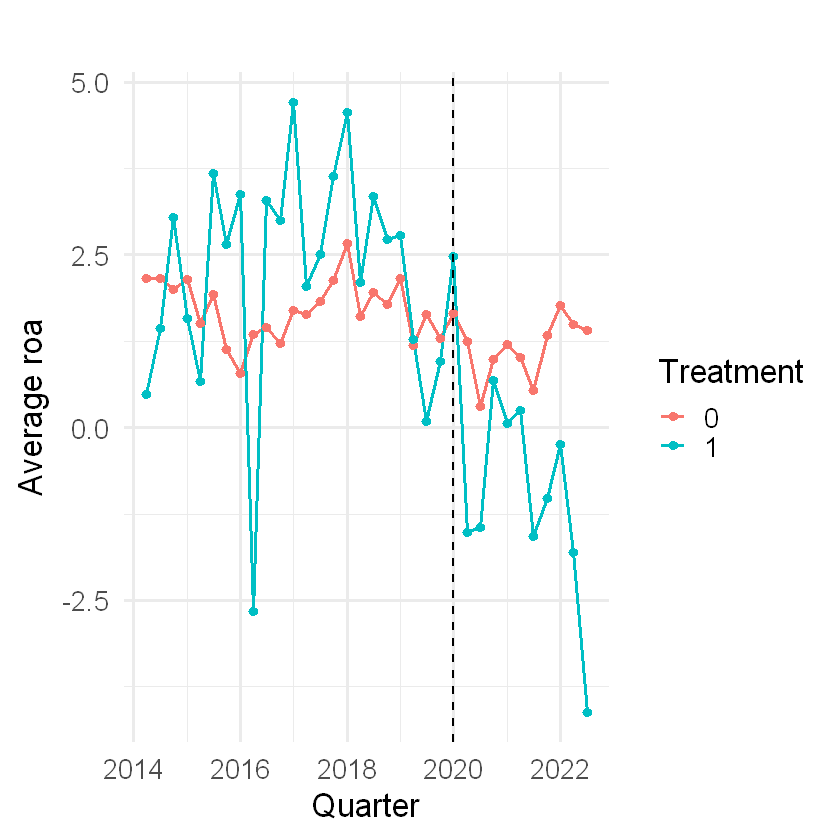

In [810]:
plot_means(df_out, "roa")

In [811]:
make_pre_post_df <- function(df, pre_q_char, post_q_char) {
  pre_q  <- as.Date(pre_q_char)
  post_q <- as.Date(post_q_char)

  # --- 1) pre-negyedév adatai (minden oszlop marad) ---
  df_pre <- df %>%
    dplyr::filter(Quarter == pre_q)

  # --- 2) post-negyedév: csak ROA + FinInst (és opcionálisan Quarter) ---
  df_post <- df %>%
    dplyr::filter(Quarter == post_q) %>%
    dplyr::select(FinInst, roa_post = roa)

  # --- 3) összekapcsolás bankonként ---
  df_out <- df_pre %>%
    dplyr::inner_join(df_post, by = "FinInst") %>%
    dplyr::mutate(
      roa_diff = roa_post - roa   # itt a pre-roa neve simán 'roa'
    )

  return(df_out)
}



In [868]:
pre_post_df <- make_pre_post_df(
  df_out,
  pre_q_char = "2019-12-31",
  post_q_char = "2021-09-30"
)

In [870]:
collapse_categories <- function(x, min_n = 10) {
  tab <- table(x)
  valid <- names(tab)[tab >= min_n]
  
  x_new <- ifelse(x %in% valid, as.character(x), "Other")
  factor(x_new)
}

pre_post_df <- pre_post_df %>%
  mutate(
    state   = collapse_categories(state,   min_n = 5),
    segment = collapse_categories(segment, min_n = 5)
  )


In [872]:
did_simple <- lm(roa_diff  ~ treatment, data = pre_post_df)
summary(did_simple)


Call:
lm(formula = roa_diff ~ treatment, data = pre_post_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-79.447  -1.167   0.882   3.429  46.447 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  -0.7000     0.8802  -0.795   0.4271  
treatment    -3.2815     1.4666  -2.237   0.0261 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 11.37 on 259 degrees of freedom
Multiple R-squared:  0.01896,	Adjusted R-squared:  0.01517 
F-statistic: 5.006 on 1 and 259 DF,  p-value: 0.02611


In [877]:
did_simple <- lm(roa_diff  ~ treatment + segment + log_assets + eq_assets + TD + loans_assets + dep_assets + state, data = pre_post_df)
summary(did_simple)


Call:
lm(formula = roa_diff ~ treatment + segment + log_assets + eq_assets + 
    TD + loans_assets + dep_assets + state, data = pre_post_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-65.902  -2.628   0.204   2.760  49.637 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept)  -37.47401   12.22025  -3.067  0.00241 **
treatment     -0.05798    2.04233  -0.028  0.97737   
segment198    -2.74427    3.72274  -0.737  0.46174   
segment199    -2.47514    3.21451  -0.770  0.44206   
segment9       0.15608    2.53113   0.062  0.95088   
segmentOther  -2.17624    5.61723  -0.387  0.69879   
log_assets     1.58824    0.49382   3.216  0.00148 **
eq_assets     -0.25546    4.07725  -0.063  0.95009   
TDI            3.80736    2.68546   1.418  0.15755   
loans_assets   1.58842    0.91269   1.740  0.08307 . 
dep_assets     1.47139    3.06013   0.481  0.63108   
stateGO        3.61820    5.29127   0.684  0.49476   
stateMG        1.42475    3.95851   0.360  0.7

In [1047]:
psm_seg2 <- matchit(
  treatment ~ log_assets + eq_assets + dep_assets +
    loans_assets + adminexp_assets,
  data   = pre_post_df,
  method = "nearest",
  ratio  = 5,
  caliper = 0.05,
  distance = "logit"
)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"Not all treated units will get 5 matches."


In [1048]:
summary(psm_seg2)


Call:
matchit(formula = treatment ~ log_assets + eq_assets + dep_assets + 
    loans_assets + adminexp_assets, data = pre_post_df, method = "nearest", 
    distance = "logit", caliper = 0.05, ratio = 5)

Summary of Balance for All Data:
                Means Treated Means Control Std. Mean Diff. Var. Ratio
distance               0.6972        0.1705          2.1639     1.0898
log_assets            17.2787       20.7193         -1.8060     0.5467
eq_assets              0.3418        0.2625          0.2779     1.5021
dep_assets             0.3719        0.3254          0.1679     0.8772
loans_assets           0.0796        0.3108         -1.7442     0.0177
adminexp_assets        0.0185        0.0140          0.1754     0.3090
                eCDF Mean eCDF Max
distance           0.4216   0.7133
log_assets         0.3623   0.6867
eq_assets          0.0797   0.1601
dep_assets         0.0653   0.1686
loans_assets       0.1761   0.4072
adminexp_assets    0.1466   0.2735

Summary of Balance 

In [1049]:
summary(psm_seg2)$sum.matched

,Means Treated,Means Control,Std. Mean Diff.,Var. Ratio,eCDF Mean,eCDF Max,Std. Pair Dist.
distance,0.50287199,0.49788463,0.020489572,1.0330588,0.009203805,0.05263158,0.03056565
log_assets,18.14627799,18.22556895,-0.041620399,1.6681495,0.047146602,0.15526316,0.73568112
eq_assets,0.37605038,0.35898041,0.059821078,1.3921704,0.043456342,0.12105263,0.82959483
dep_assets,0.29396987,0.31787599,-0.086338510,0.8662411,0.062380007,0.15570175,1.06369353
loans_assets,0.09906939,0.09844823,0.004687441,1.1059185,0.055059824,0.16096491,1.32801049
adminexp_assets,0.01634512,0.01627290,0.002807322,1.3650929,0.045992136,0.12324561,0.59399229


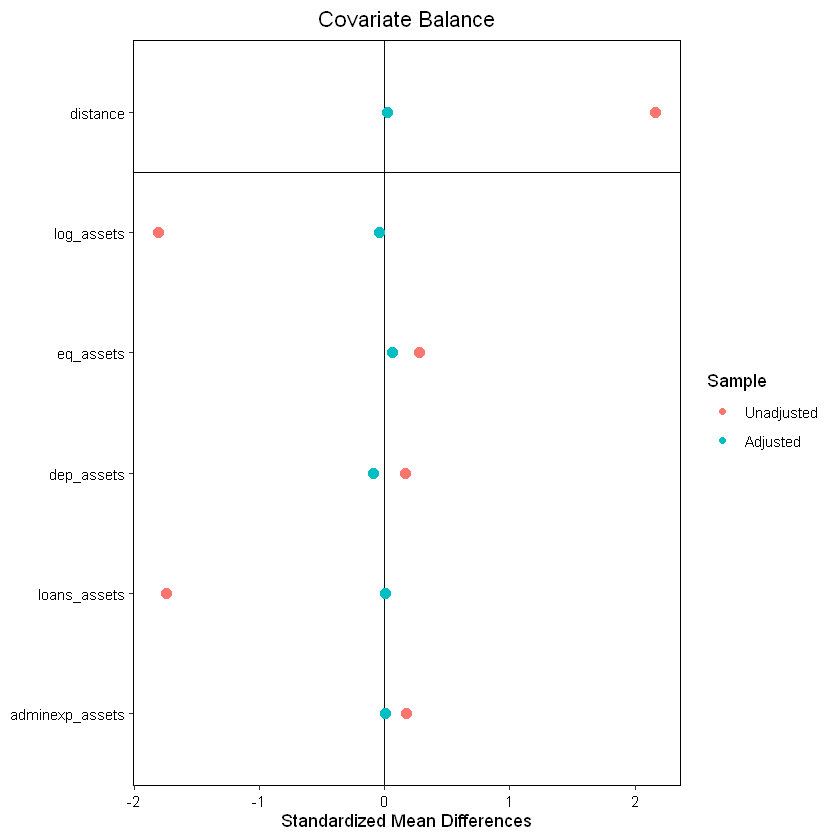

In [1050]:
library(cobalt)
love.plot(psm_seg2, binary = "std")

In [1051]:
matched_df <- match.data(psm_seg2)


In [1052]:
model_ate <- lm(roa_diff ~ treatment, data = matched_df, weights = weights)

summary(model_ate)


Call:
lm(formula = roa_diff ~ treatment, data = matched_df, weights = weights)

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-80.421  -0.641   1.579   3.656  28.163 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)   -2.037      1.584  -1.286    0.201
treatment     -0.970      2.620  -0.370    0.712

Residual standard error: 12.86 on 102 degrees of freedom
Multiple R-squared:  0.001342,	Adjusted R-squared:  -0.008448 
F-statistic: 0.1371 on 1 and 102 DF,  p-value: 0.7119


In [1053]:
model_ate <- lm(roa_diff ~ treatment + log_assets + eq_assets + loans_assets + dep_assets, data = matched_df, weights = weights)

summary(model_ate)



Call:
lm(formula = roa_diff ~ treatment + log_assets + eq_assets + 
    loans_assets + dep_assets, data = matched_df, weights = weights)

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-60.269  -5.496  -0.970   4.548  26.936 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -76.5227    19.2285  -3.980 0.000132 ***
treatment     -0.6139     2.3326  -0.263 0.792968    
log_assets     3.7068     0.9258   4.004 0.000121 ***
eq_assets      6.0627     6.5558   0.925 0.357343    
loans_assets  23.8734     7.7156   3.094 0.002572 ** 
dep_assets     7.5525     4.5936   1.644 0.103351    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 11.44 on 98 degrees of freedom
Multiple R-squared:  0.241,	Adjusted R-squared:  0.2023 
F-statistic: 6.224 on 5 and 98 DF,  p-value: 4.708e-05


In [1008]:
plot_matched_quarterly_means <- function(
  df_out, matched_df, varname, covid_q = "2019-12-31"
) {
  # Ellenőrzések
  if (!varname %in% names(df_out)) {
    stop(paste("A(z)", varname, "változó nem található df_out-ban."))
  }
  if (!"weights" %in% names(matched_df)) {
    stop("A matched_df nem tartalmaz 'weights' oszlopot.")
  }

  covid_q <- as.Date(covid_q)

  # --- 1) matched bankok FinInst listája ---
  matched_banks <- unique(matched_df$FinInst)

  # --- 2) treatment + weights visszacsatolása ---
  weights_info <- matched_df %>%
    dplyr::select(FinInst, treatment, weights)

  # --- 3) teljes panel + matched súlyok ---
  df_panel <- df_out %>%
    dplyr::filter(FinInst %in% matched_banks) %>%
    dplyr::left_join(weights_info, by = c("FinInst", "treatment"))

  # --- 4) negyedéves súlyozott átlagok ---
  df_plot <- df_panel %>%
    dplyr::group_by(Quarter, treatment) %>%
    dplyr::summarise(
      weighted_mean = weighted.mean(.data[[varname]], weights, na.rm = TRUE),
      .groups = "drop"
    )

  # --- 5) széles ábra + COVID-vonal ---
  ggplot2::ggplot(df_plot, ggplot2::aes(
      x = Quarter,
      y = weighted_mean,
      color = factor(treatment)
    )) +
    ggplot2::geom_line(size = 1.3) +
    ggplot2::geom_point(size = 2.2) +
    ggplot2::geom_vline(
      xintercept = as.numeric(covid_q),
      color = "black",
      linewidth = 1,
      linetype = "solid"
    ) +
    ggplot2::labs(
      title = paste("Súlyozott negyedéves átlagok (matched):", varname),
      x = "Negyedév",
      y = paste("Súlyozott", varname, "átlag"),
      color = "Treatment"
    ) +
    ggplot2::theme_minimal(base_size = 24) +
    ggplot2::theme(
      plot.margin = ggplot2::margin(20, 40, 20, 40),
      legend.position = "top",
      aspect.ratio = 0.5   # nagyon széles, lapos ábra
    )
}


In [1009]:
plot_matched_quarterly_means <- function(
  df_out,
  matched_df,
  varname,
  covid_date = as.Date("2019-12-31")   # COVID starting quarter
) {
  # --- 0) Checks ---
  if (!varname %in% names(df_out)) {
    stop(paste("Variable", varname, "not found in df_out."))
  }
  if (!"weights" %in% names(matched_df)) {
    stop("matched_df must contain a 'weights' column.")
  }
  if (!"FinInst" %in% names(matched_df)) {
    stop("matched_df must contain a 'FinInst' column.")
  }
  if (!"treatment" %in% names(matched_df)) {
    stop("matched_df must contain a 'treatment' column.")
  }
  if (!"Quarter" %in% names(df_out)) {
    stop("df_out must contain a 'Quarter' column.")
  }
  if (!"treatment" %in% names(df_out)) {
    stop("df_out must contain a 'treatment' column.")
  }

  # --- 1) List of matched banks ---
  matched_banks <- unique(matched_df$FinInst)

  # --- 2) Treatment + weights info ---
  weights_info <- matched_df %>%
    dplyr::select(FinInst, treatment, weights)

  # --- 3) Full panel restricted to matched banks + weights ---
  df_panel <- df_out %>%
    dplyr::filter(FinInst %in% matched_banks) %>%
    dplyr::left_join(weights_info, by = c("FinInst", "treatment"))

  # --- 4) Quarterly weighted means ---
  df_plot <- df_panel %>%
    dplyr::group_by(Quarter, treatment) %>%
    dplyr::summarise(
      weighted_mean = weighted.mean(.data[[varname]], weights, na.rm = TRUE),
      .groups       = "drop"
    )

  # --- 5) Plot (style matched to plot_means) ---
  p <- ggplot2::ggplot(
    df_plot,
    ggplot2::aes(
      x     = Quarter,
      y     = weighted_mean,
      color = factor(treatment)
    )
  ) +
    ggplot2::geom_line(size = 0.9) +
    ggplot2::geom_point(size = 2) +
    ggplot2::geom_vline(
      xintercept = covid_date,
      linetype   = "dashed",
      color      = "black",
      linewidth  = 0.7
    ) +
    ggplot2::labs(
      title = "",
      x     = "Quarter",
      y     = paste0("Weighted average ", varname),
      color = "Treatment"
    ) +
    ggplot2::theme_minimal(base_size = 20)

  # Optional: save figure (similar to plot_means)
  ggplot2::ggsave("matched_weighted_plot.png", plot = p, width = 12, height = 5, dpi = 300)

  return(p)
}


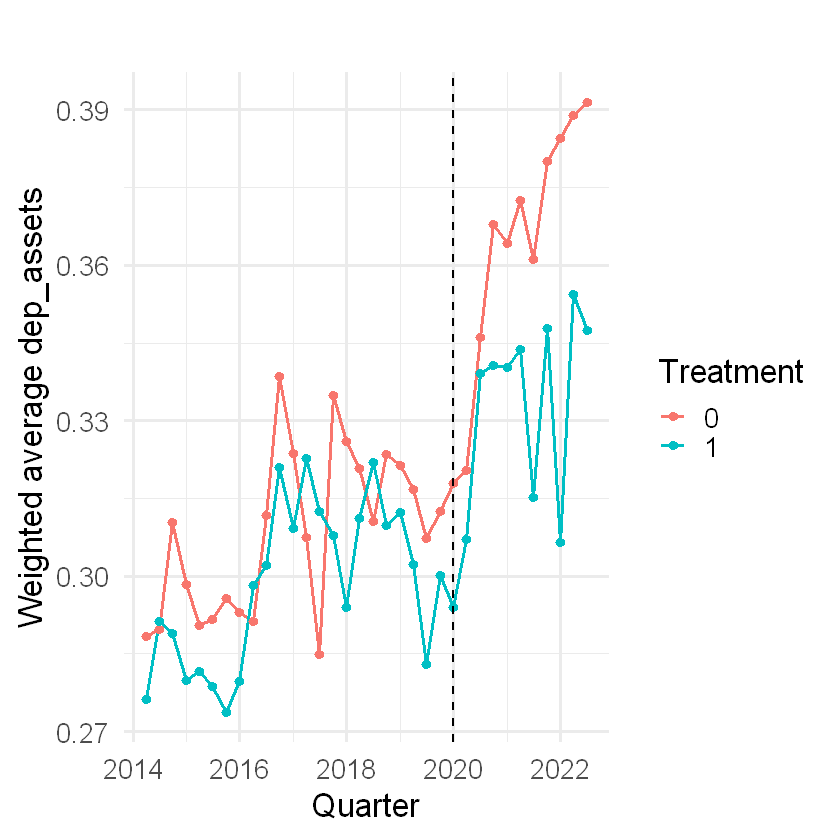

In [1025]:
plot_matched_quarterly_means(
  df_out    = df_out,
  matched_df = matched_df,
  varname   = "dep_assets"
)

In [1011]:
df_out <- df_out %>%
  dplyr::mutate(
    post = ifelse(Quarter >= as.Date("2020-03-31"), 1L, 0L)
  )


In [1062]:
did_model <- feols(
  roa ~ treatment * post + log_assets + eq_assets  + loans_assets + dep_assets +state + segment +TD | FinInst + Quarter,
  data = df_out
)
summary(did_model)

The variables 'treatment', 'post', 'stateAL', 'stateAM', 'stateAP', 'stateBA'
and 23 others have been removed because of collinearity (see $collin.var).



OLS estimation, Dep. Var.: roa
Observations: 8,717
Fixed-effects: FinInst: 294,  Quarter: 34
Standard-errors: IID 
                Estimate Std. Error   t value   Pr(>|t|)    
log_assets      4.889480   0.298112 16.401481  < 2.2e-16 ***
eq_assets      17.624027   1.396976 12.615840  < 2.2e-16 ***
loans_assets   -0.079003   0.183406 -0.430756 6.6666e-01    
dep_assets      1.231668   1.144717  1.075958 2.8198e-01    
stateCE        40.188755   3.235005 12.423089  < 2.2e-16 ***
stateMG        -4.183376   4.392313 -0.952431 3.4091e-01    
stateRS         9.030908   4.312259  2.094241 3.6269e-02 *  
segment196     10.191690   8.777445  1.161123 2.4563e-01    
segment197      3.231386   1.620738  1.993775 4.6209e-02 *  
segment198      3.475873   1.497635  2.320907 2.0316e-02 *  
TDI             1.262167   0.703956  1.792964 7.3015e-02 .  
treatment:post -2.561198   0.417317 -6.137300 8.7749e-10 ***
... 29 variables were removed because of collinearity (treatment, post
and 27 others [full s

In [1058]:
did_model <- feols(
  roa ~ treatment * post | FinInst + Quarter,
  data = df_panel
)
summary(did_model)


The variables 'treatment' and 'post' have been removed because of collinearity
(see $collin.var).



OLS estimation, Dep. Var.: roa
Observations: 3,098
Fixed-effects: FinInst: 104,  Quarter: 34
Standard-errors: IID 
               Estimate Std. Error  t value Pr(>|t|) 
treatment:post -0.87331   0.645671 -1.35256   0.1763 
... 2 variables were removed because of collinearity (treatment and
post)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 7.75912     Adj. R2: 0.276621
                Within R2: 6.177e-4

In [1014]:
did_model <- feols(
  roa ~ treatment * post + log_assets + eq_assets  + loans_assets + dep_assets  | FinInst + Quarter,
  data = df_panel
)
summary(did_model)



The variables 'treatment' and 'post' have been removed because of collinearity
(see $collin.var).



OLS estimation, Dep. Var.: roa
Observations: 3,098
Fixed-effects: FinInst: 104,  Quarter: 34
Standard-errors: IID 
               Estimate Std. Error   t value   Pr(>|t|)    
log_assets      2.37167   0.484683  4.893239 1.0450e-06 ***
eq_assets       6.90088   2.481436  2.781002 5.4535e-03 ** 
loans_assets   -8.22492   2.093186 -3.929379 8.7116e-05 ***
dep_assets     -1.86210   1.964405 -0.947920 3.4325e-01    
treatment:post -1.06595   0.646299 -1.649311 9.9190e-02 .  
... 2 variables were removed because of collinearity (treatment and
post)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 7.69448     Adj. R2: 0.287661
                Within R2: 0.0172  

In [983]:
  # --- 1) matched bankok FinInst listája ---
  matched_banks <- unique(matched_df$FinInst)

  # --- 2) treatment + weights visszacsatolása ---
  weights_info <- matched_df %>%
    dplyr::select(FinInst, treatment, weights)

  # --- 3) teljes panel + matched súlyok ---
  df_panel <- df_out %>%
    dplyr::filter(FinInst %in% matched_banks) %>%
    dplyr::left_join(weights_info, by = c("FinInst", "treatment"))

In [935]:
library(fixest)


In [948]:
es_model <- feols(
  roa ~ i(Quarter, treatment, ref = "2020-03-31") +
        log_assets + eq_assets + loans_assets + dep_assets +
        state + TD + segment |
        FinInst + Quarter,
  data = df_panel
)

summary(es_model)


The variables 'Quarter::2022-06-30:treatment', 'stateAL', 'stateAM', 'stateAP',
'stateBA', 'stateCE' and 25 others have been removed because of collinearity
(see $collin.var).



OLS estimation, Dep. Var.: roa
Observations: 2,367
Fixed-effects: FinInst: 79,  Quarter: 34
Standard-errors: IID 
                               Estimate Std. Error   t value   Pr(>|t|)    
Quarter::2014-03-31:treatment  0.869117   2.613062  0.332605 0.73946400    
Quarter::2014-06-30:treatment -0.601119   2.603700 -0.230871 0.81743622    
Quarter::2014-09-30:treatment  3.266734   2.548886  1.281632 0.20010602    
Quarter::2014-12-31:treatment  1.920576   2.498548  0.768677 0.44216714    
Quarter::2015-03-31:treatment  2.728529   2.532605  1.077361 0.28143650    
Quarter::2015-06-30:treatment -0.328513   2.485748 -0.132158 0.89487096    
Quarter::2015-09-30:treatment  4.995975   2.482624  2.012377 0.04430110 *  
Quarter::2015-12-31:treatment  2.718088   2.504847  1.085131 0.27798175    
Quarter::2016-03-31:treatment  0.695113   2.504590  0.277536 0.78139471    
Quarter::2016-06-30:treatment -1.084673   2.483049 -0.436831 0.66227649    
Quarter::2016-09-30:treatment  1.161705   2.468371

In [944]:
wald(es_model, keep = "Quarter::201[4-9]-.*:treatment")


Wald test, H0: joint nullity of Quarter::2014-03-31:treatment, Quarter::2014-06-30:treatment, Quarter::2014-09-30:treatment, Quarter::2014-12-31:treatment, Quarter::2015-03-31:treatment, Quarter::2015-06-30:treatment and 18 others
 stat = 1.32351, p-value = 0.134739, on 24 and 2,214 DoF, VCOV: IID.

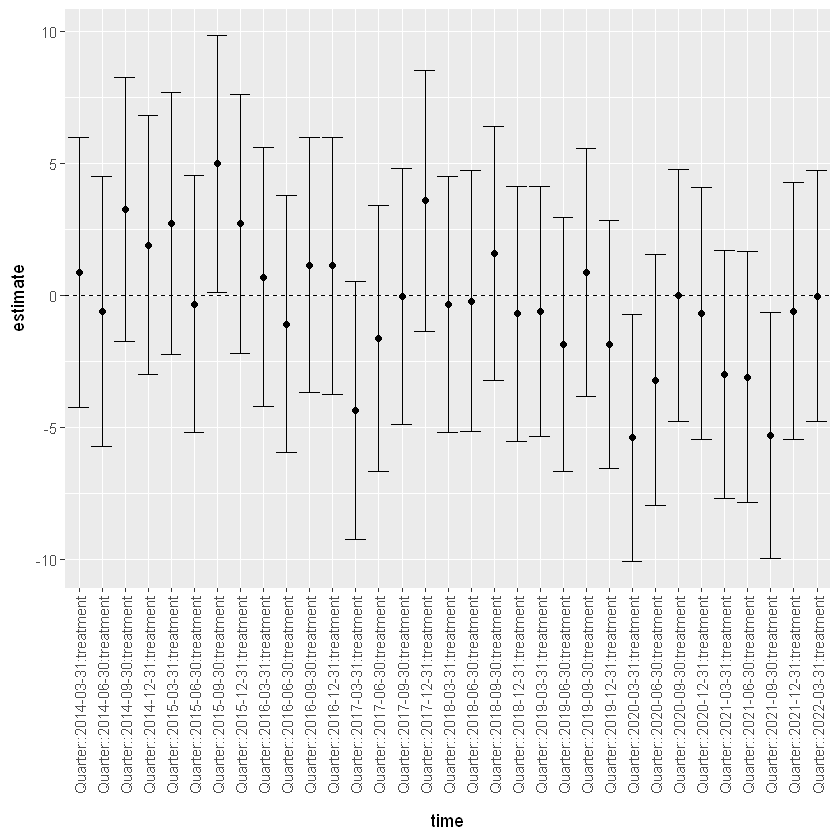

In [945]:
# Koeficiens + s.e. kihúzása event study-tagokra
ev_coefs <- broom::tidy(es_model)

# Szűrés csak a Quarter × treatment tagokra
library(dplyr)
library(stringr)

ev_plot_df <- ev_coefs %>%
  filter(str_detect(term, "Quarter::")) %>%
  mutate(
    # ebből csinálsz idősort (pl. faktor ordering vagy parse-olt év+negyedév)
    time = term
  )

# Pl. ggplot-tal felrajzolod (ha használsz ggplot2-t)
library(ggplot2)

ggplot(ev_plot_df, aes(x = time, y = estimate)) +
  geom_point() +
  geom_errorbar(aes(ymin = estimate - 1.96*std.error,
                    ymax = estimate + 1.96*std.error)) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))



Warning message:
"a(z) 'broom' csomag az R 4.4.3 verziójával lett fordítva"


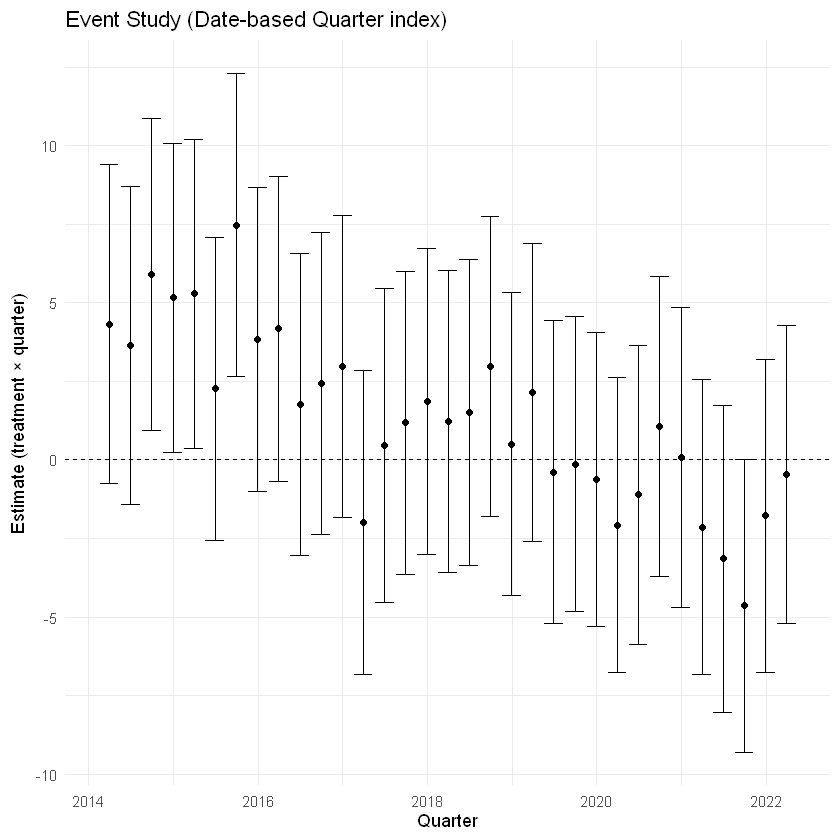

In [904]:
library(broom)
library(dplyr)
library(stringr)
library(ggplot2)

ev <- tidy(es_model) %>%
  filter(str_detect(term, "Quarter::")) %>%
  mutate(
    time = as.Date(str_extract(term, "\\d{4}-\\d{2}-\\d{2}"))
  )

ggplot(ev, aes(x = time, y = estimate)) +
  geom_point() +
  geom_errorbar(aes(ymin = estimate - 1.96 * std.error,
                    ymax = estimate + 1.96 * std.error)) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  theme_minimal() +
  labs(title = "Event Study (Date-based Quarter index)",
       x = "Quarter",
       y = "Estimate (treatment × quarter)")
